In [536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

# Read the data

In [537]:
customer_data = pd.read_csv('Customer Details.csv')
renewal_data = pd.read_csv('Renewal Details.csv')

In [538]:
customer_data.head()

,Customer_ID,Renewal_or_Non-renewal_Date,Zip_Code_Distance_From_Stadium,Tenure_As_Season_Ticket_Member
0,262688,9/4/2013,37.556232,1
1,262688,8/4/2014,37.556232,2
2,262719,7/16/2013,15.340993,1
3,262719,8/4/2014,15.340993,2
4,262782,7/16/2013,21.569895,8


In [539]:
renewal_data.head()

,Customer_ID,Previous_Season,Renewal_Season,Renewal,Renewal_or_Non-renewal_Date,Average_Price_Paid_Per_Seat_Previous_Season,Total_Seats_Previous_Season,Team_Win_Pct_Previous_Season,Games_Attended_Previous_Season,Games_Missed_Previous_Season,Total_Games_Previous_Season,Non-Game_Events_Attended_Previous_Season,Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date,Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date,Emails_Sent_Last_90_Days_Before_Renewal_Date,Section_Previous_Season
0,262688,2012 Basketball Season Tickets,2013 Basketball Season Tickets,1,4-Sep-13,277.44,2,0.54,17,0,17,0,0,0,0,Reserved_Seats
1,262719,2012 Basketball Season Tickets,2013 Basketball Season Tickets,1,16-Jul-13,308.16,2,0.54,14,3,17,4,14,7,1,Reserved_Seats
2,262782,2012 Basketball Season Tickets,2013 Basketball Season Tickets,1,16-Jul-13,449.28,1,0.54,10,7,17,0,19,2,12,Reserved_Seats
3,263277,2012 Basketball Season Tickets,2013 Basketball Season Tickets,1,16-Jul-13,290.88,2,0.54,17,0,17,1,16,4,8,Reserved_Seats
4,263410,2012 Basketball Season Tickets,2013 Basketball Season Tickets,1,16-Jul-13,449.28,4,0.54,15,2,17,4,18,5,6,Reserved_Seats


# 1. Discovery

# Retention Model for Season Ticket Renewals

## Objective of the Model
The primary objective of this retention model is to predict whether a customer will renew their season tickets. This model will assist the basketball team’s ticketing department in identifying customers at risk of non-renewal and enable proactive retention strategies to improve renewal rates.

---

## Approach and Methodology

### 1. Data Understanding and Preparation

#### Explore the Data
- **Objective**: Examine distributions, summary statistics, and visualize key variables.
- **Key Variables to Examine**: Season tickets purchased, winning percentage, home games attended, customer distance from stadium, etc.

#### Identify Key Variables
- **Potential Influencing Factors**: Game attendance, distance from stadium, tenure, contact touchpoints (phone calls, emails), and prior spending may heavily influence renewal likelihood.

#### Handle Missing Data
- **Action**: Investigate and address missing values, such as cases where customers didn’t renew and thus have no renewal date.

#### Feature Engineering
- **Convert Categorical Variables**: Transform variables (e.g., seating section) into dummy/indicator variables.
- **Create Additional Features**:
  - **Average home game attendance rate**: `games attended/total home games`
  - **Engaged**: `Non-Game_Events_Attended_Previous_Season>0`
- **Date Normalization**: Standardize date formats across datasets and ensure alignment for merging.

### 2. Data Merging and Integration
- **Merge Datasets**: Use `CustomerID` and `Renewal_or_Non-renewal_Date` to merge the `Renewal` and `Customer` datasets. 


### 3. Exploratory Data Analysis (EDA)

#### Correlation Analysis
- **Objective**: Identify factors most correlated with renewal behavior, such as game attendance, winning percentage, date and ticket price.

#### Visualizations
- **Types**: Use histograms, bar charts, and scatter plots to explore relationships, especially those with the target variable (renewed or not).

#### Class Imbalance
- Check for any significant imbalance between customers who renewed and those who didn’t, as it may impact model performance and selection.

### 4. Feature Selection and Model Building

#### Define Target Variable
- **Binary Classification**:  `1` for customers who renewed and `0` for those who didn’t.

#### Algorithm Consideration
- **Logistic Regression**: Interpretable model for binary classification; useful for understanding feature impact on renewal likelihood.
- **Random Forest/Gradient Boosting (e.g., XGBoost, LightGBM)**: Suitable for capturing non-linear relationships and providing feature importance insights.
- **Support Vector Machines (SVM)**: Useful for complex, non-linear distributions; requires tuning in high-dimensional data.
- **K-Nearest Neighbors (KNN)**: Performs well on smaller datasets; may struggle with larger datasets and high-dimensional data.
- **Neural Networks**: Can capture complex patterns in large datasets but require more tuning and data.

- For the sake of simplicity we will stick to Logistic Regression, Random Forest and XGBoost

### 5. Model Evaluation

#### Train/Test Split
- **Objective**: Use cross-validation or a train/test split to ensure model generalization.

#### Metrics
- **Accuracy**: Helpful, but limited if class imbalance exists.
- **Precision, Recall, F1-score**: Focus on recall if the goal is to minimize false negatives (predicting non-renewal when the customer actually renews).
- **AUC-ROC**: Evaluate the model’s ability to distinguish between renewals and non-renewals.
- **Feature Importance**: For models like random forests, analyze feature importance to identify the most influential factors.

### 6. Model Optimization and Deployment

#### Hyperparameter Tuning
- **Method**: Use grid search or random search to tune hyperparameters, such as tree depth for decision trees or learning rates for gradient boosting.

#### Final Model Selection
- **Criteria**: Choose the best-performing model based on cross-validation and evaluation metrics. Refine it for production use.

#### Deployment Considerations
- **Pipeline Development**: If deploying for regular use, build pipelines for real-time or batch predictions as new data comes in.

---

## Analytical Tools/Algorithms to Consider

- **Python Libraries**:
  - `Pandas` for data manipulation and cleaning.
  - `Scikit-learn` for logistic regression, tree-based models, SVMs, and model evaluation metrics.
  - `XGBoost/LightGBM` for gradient boosting algorithms.
  - `Matplotlib` for visualizing correlations and distributions.
- **SQL**: For merging and querying large datasets, if necessary.
- **Tableau/Looker**: For post-modeling visualization and reporting insights to non-technical stakeholders.

# 2. Data Preparation and Initial Data Analysis(IDA)

In [540]:
# Step 1: Explore basic information and structure of datasets
print("Renewal Data Info:")
print(renewal_data.info())

Renewal Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 16 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Customer_ID                                                              3781 non-null   int64  
 1   Previous_Season                                                          3781 non-null   object 
 2   Renewal_Season                                                           3781 non-null   object 
 3   Renewal                                                                  3781 non-null   int64  
 4   Renewal_or_Non-renewal_Date                                              3781 non-null   object 
 5   Average_Price_Paid_Per_Seat_Previous_Season                              3781 non-null   float64
 6   Total_Seats_Previous_Season                          

In [541]:
print("\nCustomer Data Info:")
print(customer_data.info())


Customer Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer_ID                     3781 non-null   int64  
 1   Renewal_or_Non-renewal_Date     3781 non-null   object 
 2   Zip_Code_Distance_From_Stadium  3701 non-null   float64
 3   Tenure_As_Season_Ticket_Member  3781 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 118.3+ KB
None


In [542]:
customer_data.shape, renewal_data.shape

((3781, 4), (3781, 16))

In [543]:
# Step 2: Handling missing values (NAs/nulls)
# Checking for missing values in each dataframe
print("Missing values in Renewal Data:")
print(renewal_data.isnull().sum())

Missing values in Renewal Data:
Customer_ID                                                                0
Previous_Season                                                            0
Renewal_Season                                                             0
Renewal                                                                    0
Renewal_or_Non-renewal_Date                                                0
Average_Price_Paid_Per_Seat_Previous_Season                                0
Total_Seats_Previous_Season                                                0
Team_Win_Pct_Previous_Season                                               0
Games_Attended_Previous_Season                                             0
Games_Missed_Previous_Season                                               0
Total_Games_Previous_Season                                                0
Non-Game_Events_Attended_Previous_Season                                   0
Phone_Calls_Made_to_Customer_Last_90_Days_Be

In [544]:
print("\nMissing values in Customer Data:")
print(customer_data.isnull().sum())


Missing values in Customer Data:
Customer_ID                        0
Renewal_or_Non-renewal_Date        0
Zip_Code_Distance_From_Stadium    80
Tenure_As_Season_Ticket_Member     0
dtype: int64


In [545]:
# Filling missing values
customer_data['Zip_Code_Distance_From_Stadium'] = customer_data['Zip_Code_Distance_From_Stadium'].fillna(customer_data['Zip_Code_Distance_From_Stadium'].median())

In [546]:
# Step 3: Checking date formats in both datasets
print("\nRenewal Date Format Check:")
print(renewal_data['Renewal_or_Non-renewal_Date'].head())

print("\nCustomer Renewal Date Format Check:")
print(customer_data['Renewal_or_Non-renewal_Date'].head())


Renewal Date Format Check:
0     4-Sep-13
1    16-Jul-13
2    16-Jul-13
3    16-Jul-13
4    16-Jul-13
Name: Renewal_or_Non-renewal_Date, dtype: object

Customer Renewal Date Format Check:
0     9/4/2013
1     8/4/2014
2    7/16/2013
3     8/4/2014
4    7/16/2013
Name: Renewal_or_Non-renewal_Date, dtype: object


In [547]:
# Converting 'Renewal Date' to datetime if not in correct format
renewal_data['Renewal_or_Non-renewal_Date'] = pd.to_datetime(renewal_data['Renewal_or_Non-renewal_Date'], errors='coerce')
customer_data['Renewal_or_Non-renewal_Date'] = pd.to_datetime(customer_data['Renewal_or_Non-renewal_Date'], errors='coerce')

/var/folders/vy/x91b4v216pz4sptwpws0q_s40000gn/T/ipykernel_12613/4068037063.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  renewal_data['Renewal_or_Non-renewal_Date'] = pd.to_datetime(renewal_data['Renewal_or_Non-renewal_Date'], errors='coerce')


In [548]:
# Step 4: Merging the datasets based on 'Customer ID' and 'Renewal Date'
# We use an inner join to combine data on customers present in both datasets
combined_data = pd.merge(renewal_data, customer_data, how='inner', on=['Customer_ID', 'Renewal_or_Non-renewal_Date'])

print("\nCombined Data Info:")
print(combined_data.info())


Combined Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 18 columns):
 #   Column                                                                   Non-Null Count  Dtype         
---  ------                                                                   --------------  -----         
 0   Customer_ID                                                              3781 non-null   int64         
 1   Previous_Season                                                          3781 non-null   object        
 2   Renewal_Season                                                           3781 non-null   object        
 3   Renewal                                                                  3781 non-null   int64         
 4   Renewal_or_Non-renewal_Date                                              3779 non-null   datetime64[ns]
 5   Average_Price_Paid_Per_Seat_Previous_Season                              3781 non-null   float64       


In [549]:
# Looks like there are some missing values in the 'Renewal_or_Non-renewal_Date' column due to the merge. 
# Let us fill them with the previous available date value.
combined_data['Renewal_or_Non-renewal_Date'] = combined_data['Renewal_or_Non-renewal_Date'].ffill()

In [550]:
# Step 5: Additional data checks (e.g., identifying outliers, invalid data)
# Example: Checking for negative or unrealistic values in 'Total season tickets purchased'
print("\nChecking for unrealistic values in 'Total season tickets purchased':")
print(combined_data[combined_data['Total_Seats_Previous_Season'] < 0])


Checking for unrealistic values in 'Total season tickets purchased':
Empty DataFrame
Columns: [Customer_ID, Previous_Season, Renewal_Season, Renewal, Renewal_or_Non-renewal_Date, Average_Price_Paid_Per_Seat_Previous_Season, Total_Seats_Previous_Season, Team_Win_Pct_Previous_Season, Games_Attended_Previous_Season, Games_Missed_Previous_Season, Total_Games_Previous_Season, Non-Game_Events_Attended_Previous_Season, Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date, Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date, Emails_Sent_Last_90_Days_Before_Renewal_Date, Section_Previous_Season, Zip_Code_Distance_From_Stadium, Tenure_As_Season_Ticket_Member]
Index: []


In [551]:
# Step 6: Additional features engineering (if applicable)
# Creating a new feature: attendance rate (games attended / total games)
combined_data['Attendance_Rate'] = combined_data['Games_Attended_Previous_Season'] / combined_data['Total_Games_Previous_Season']

# Creating a feature for whether the customer was actively engaged (participated in any non-game events)
combined_data['Engaged_In_Events'] = np.where(combined_data['Non-Game_Events_Attended_Previous_Season'] > 0, 1, 0)

In [552]:
# Step 7: Categorical variables check

In [553]:
combined_data['Previous_Season'].unique()


array(['2012 Basketball Season Tickets', '2013 Basketball Season Tickets'],
      dtype=object)

In [554]:
combined_data['Renewal_Season'].unique()

array(['2013 Basketball Season Tickets', '2014 Basketball Season Tickets'],
      dtype=object)

In [555]:
combined_data['Section_Previous_Season'].unique()

array(['Reserved_Seats', 'Platinum_Club', 'General_Admission',
       'Club_Level'], dtype=object)

Since the columns 'Previous_Season' and 'Renewal_Season' have only 2 values each, there is not a lot of information to be gained, so we can drop them. We can perform label encoding for the column 'Section_Previous_Season'. Let us also drop Customer_ID as a unique identifier won't be providing relevant information for our model predictions

In [557]:
# Drop the columns 'Previous_Season', 'Renewal_Season' and 'Renewal_or_Non-renewal_Date'
combined_data = combined_data.drop(columns=['Previous_Season', 'Renewal_Season', 'Customer_ID'])

In [558]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
combined_data['Section_Previous_Season'] = label_encoder.fit_transform(combined_data['Section_Previous_Season'])

# Display the first few rows of the modified DataFrame
combined_data.head()

,Renewal,Renewal_or_Non-renewal_Date,Average_Price_Paid_Per_Seat_Previous_Season,Total_Seats_Previous_Season,Team_Win_Pct_Previous_Season,Games_Attended_Previous_Season,Games_Missed_Previous_Season,Total_Games_Previous_Season,Non-Game_Events_Attended_Previous_Season,Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date,Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date,Emails_Sent_Last_90_Days_Before_Renewal_Date,Section_Previous_Season,Zip_Code_Distance_From_Stadium,Tenure_As_Season_Ticket_Member,Attendance_Rate,Engaged_In_Events
0,1,2013-09-04,277.44,2,0.54,17,0,17,0,0,0,0,3,37.556232,1,1.000000,0
1,1,2013-07-16,308.16,2,0.54,14,3,17,4,14,7,1,3,15.340993,1,0.823529,1
2,1,2013-07-16,449.28,1,0.54,10,7,17,0,19,2,12,3,21.569895,8,0.588235,0
3,1,2013-07-16,290.88,2,0.54,17,0,17,1,16,4,8,3,25.821965,4,1.000000,1
4,1,2013-07-16,449.28,4,0.54,15,2,17,4,18,5,6,3,16.239354,2,0.882353,1


In [559]:
# Step 8: We should drop date as it won't be providing relevant information for our model. 
# Instead we can extract month to account for seasonality and other time based trends in the data
combined_data['Renewal_Month'] = combined_data['Renewal_or_Non-renewal_Date'].dt.month
combined_data = combined_data.drop(columns=['Renewal_or_Non-renewal_Date'])

# Display the first few rows of the modified DataFrame
combined_data.head()

,Renewal,Average_Price_Paid_Per_Seat_Previous_Season,Total_Seats_Previous_Season,Team_Win_Pct_Previous_Season,Games_Attended_Previous_Season,Games_Missed_Previous_Season,Total_Games_Previous_Season,Non-Game_Events_Attended_Previous_Season,Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date,Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date,Emails_Sent_Last_90_Days_Before_Renewal_Date,Section_Previous_Season,Zip_Code_Distance_From_Stadium,Tenure_As_Season_Ticket_Member,Attendance_Rate,Engaged_In_Events,Renewal_Month
0,1,277.44,2,0.54,17,0,17,0,0,0,0,3,37.556232,1,1.000000,0,9
1,1,308.16,2,0.54,14,3,17,4,14,7,1,3,15.340993,1,0.823529,1,7
2,1,449.28,1,0.54,10,7,17,0,19,2,12,3,21.569895,8,0.588235,0,7
3,1,290.88,2,0.54,17,0,17,1,16,4,8,3,25.821965,4,1.000000,1,7
4,1,449.28,4,0.54,15,2,17,4,18,5,6,3,16.239354,2,0.882353,1,7


In [560]:
# Step 9: Checking the final dataset
print("\nFinal Combined Dataset Info:")
print(combined_data.info())

# Save the cleaned and prepared dataset to a CSV for further modeling
combined_data.to_csv('CombinedData.csv', index=False)


Final Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 17 columns):
 #   Column                                                                   Non-Null Count  Dtype  
---  ------                                                                   --------------  -----  
 0   Renewal                                                                  3781 non-null   int64  
 1   Average_Price_Paid_Per_Seat_Previous_Season                              3781 non-null   float64
 2   Total_Seats_Previous_Season                                              3781 non-null   int64  
 3   Team_Win_Pct_Previous_Season                                             3781 non-null   float64
 4   Games_Attended_Previous_Season                                           3781 non-null   int64  
 5   Games_Missed_Previous_Season                                             3781 non-null   int64  
 6   Total_Games_Previous_Season               

### Additional Data Points Not Included but Potentially Useful

- **Customer Demographics**: Age, gender, and income level could offer insights into renewal behavior.
- **Customer Satisfaction**: Data on overall satisfaction with the team, the stadium experience, or interactions with customer service.
- **Competitor Data**: Whether a nearby team or alternative entertainment options influenced renewal decisions.
- **Weather Data**: Weather conditions during the previous season might have impacted attendance and, by extension, renewal.
- **Promotions/Discounts**: Whether the customer received any special offers or promotions in the past seasons, which could influence their decision to renew.

### Challenges in Creating the Dataset from Scratch

- **Inconsistent Data Entry**: Different departments may collect data in varying formats or have inconsistencies, such as date formats or varying representations of categorical fields (e.g., spelling variations).
- **Missing Historical Data**: Some customer data, such as tenure or past interactions, might not have been recorded, making it difficult to assess long-term behavior.
- **Complexity of Event Data**: Tracking non-game events and interactions across different platforms (phone, email) may result in fragmented or incomplete data.


# 3. Model Planning and Exploratory Data Analysis (EDA)

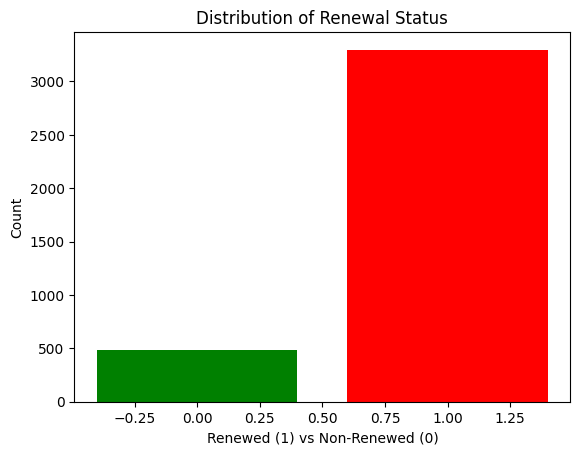

In [561]:
# Renewal status distribution
renewal_counts = renewal_data['Renewal'].value_counts()
plt.bar(renewal_counts.index, renewal_counts.values, color=['red', 'green'])
plt.xlabel('Renewed (1) vs Non-Renewed (0)')
plt.ylabel('Count')
plt.title('Distribution of Renewal Status')
plt.savefig("Distribution_Of_Renewals.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

There is a high class imbalance. We will need to perform stratified sampling to take this into account

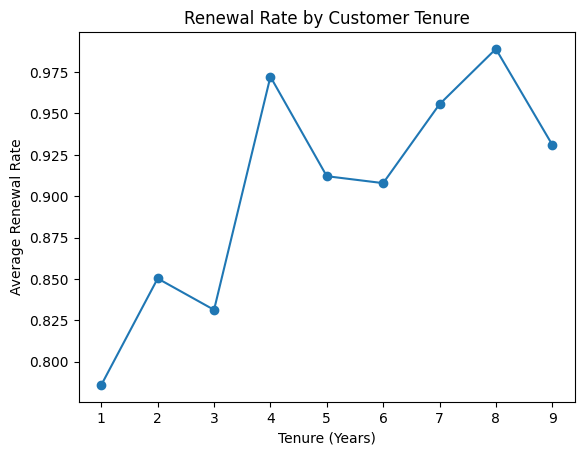

In [562]:
# Renewal rate by tenure
tenure_renewal = combined_data.groupby('Tenure_As_Season_Ticket_Member')['Renewal'].mean()
plt.plot(tenure_renewal.index, tenure_renewal.values, marker='o')
plt.xlabel('Tenure (Years)')
plt.ylabel('Average Renewal Rate')
plt.title('Renewal Rate by Customer Tenure')
plt.savefig("Renewal_Rate_By_Customer_Tenure.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/vy/x91b4v216pz4sptwpws0q_s40000gn/T/ipykernel_12613/404125532.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_bin_renewal = combined_data.groupby(price_bins)['Renewal'].sum()


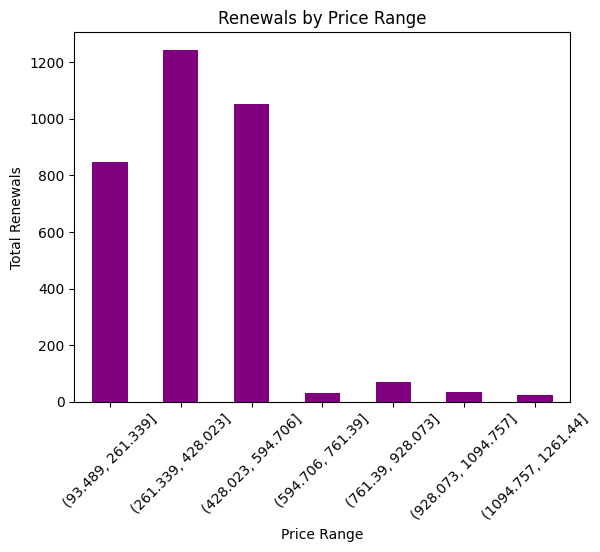

In [563]:
# Bin prices into ranges, then calculate the average renewal rate for each bin
price_bins = pd.cut(combined_data['Average_Price_Paid_Per_Seat_Previous_Season'], bins=7)
price_bin_renewal = combined_data.groupby(price_bins)['Renewal'].sum()

# Plot as a bar plot
price_bin_renewal.plot(kind='bar', color='purple')
plt.xlabel('Price Range')
plt.ylabel('Total Renewals')
plt.title('Renewals by Price Range')
plt.xticks(rotation=45)
plt.savefig("Renewals_By_Price_Range.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

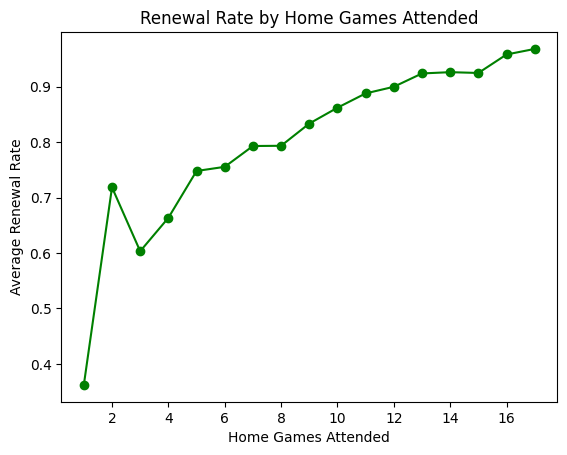

In [564]:
# Renewal rate by games attended
games_attended_renewal = combined_data.groupby('Games_Attended_Previous_Season')['Renewal'].mean()
plt.plot(games_attended_renewal.index, games_attended_renewal.values, marker='o', color='green')
plt.xlabel('Home Games Attended')
plt.ylabel('Average Renewal Rate')
plt.title('Renewal Rate by Home Games Attended')
plt.savefig("Renewal_Rate_By_Home_Games_Attended.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

/var/folders/vy/x91b4v216pz4sptwpws0q_s40000gn/T/ipykernel_12613/3153746593.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_renewal = combined_data.groupby(dist_bins)['Renewal'].mean()


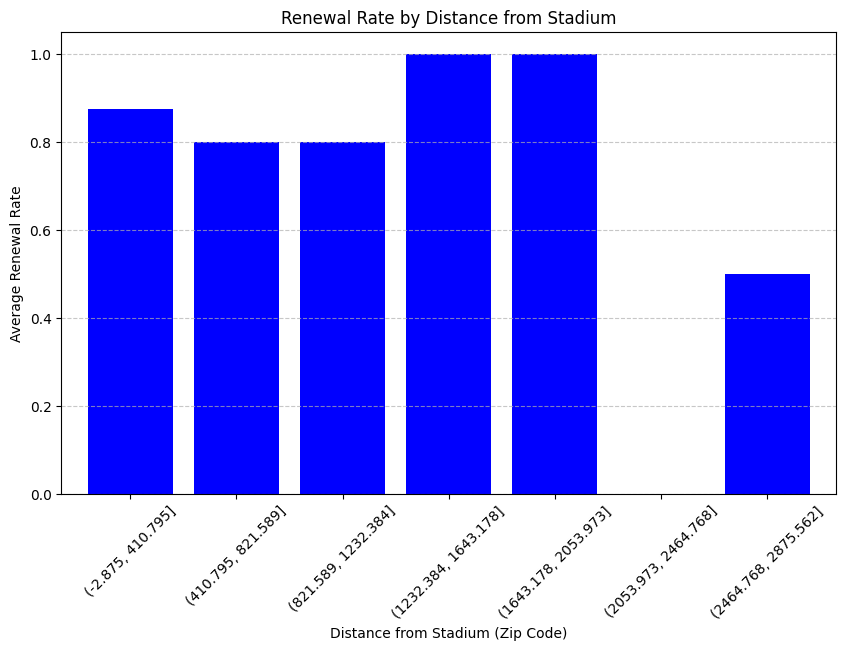

In [565]:
# Renewal rate by distance from stadium
dist_bins = pd.cut(combined_data['Zip_Code_Distance_From_Stadium'], bins=7)
distance_renewal = combined_data.groupby(dist_bins)['Renewal'].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Set the figure size for better visibility
distance_renewal.plot(kind='bar', color='blue', width=0.8)
plt.xlabel('Distance from Stadium (Zip Code)')
plt.ylabel('Average Renewal Rate')
plt.title('Renewal Rate by Distance from Stadium')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
plt.savefig("Renewal_Rate_By_Distance_From_Stadium.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

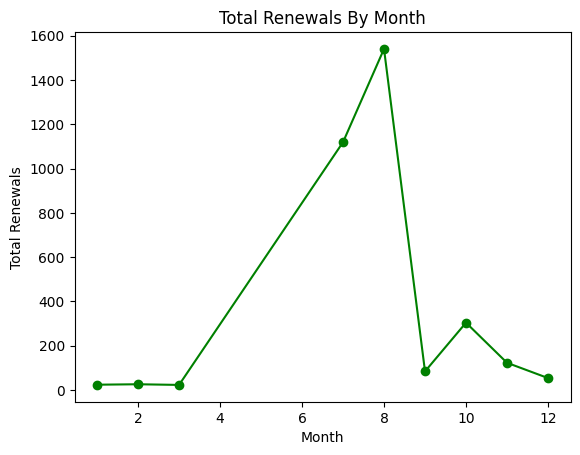

In [566]:
# Renewal rate by games attended
games_attended_renewal = combined_data.groupby('Renewal_Month')['Renewal'].sum()
plt.plot(games_attended_renewal.index, games_attended_renewal.values, marker='o', color='green')
plt.xlabel('Month')
plt.ylabel('Total Renewals')
plt.title('Total Renewals By Month')
plt.savefig("Total_Renewals_By_Month.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [567]:
# Calculate correlation matrix
correlation_matrix = combined_data.select_dtypes(include=['number']).corr()
print(correlation_matrix['Renewal'].sort_values(ascending=False))

Renewal                                                                    1.000000
Renewal_Month                                                              0.768810
Emails_Sent_Last_90_Days_Before_Renewal_Date                               0.427554
Team_Win_Pct_Previous_Season                                               0.313745
Games_Attended_Previous_Season                                             0.285498
Attendance_Rate                                                            0.285498
Live_Phone_Conversations_With_Customer_Last_90_Days_Before_Renewal_Date    0.271069
Phone_Calls_Made_to_Customer_Last_90_Days_Before_Renewal_Date              0.264443
Tenure_As_Season_Ticket_Member                                             0.201660
Average_Price_Paid_Per_Seat_Previous_Season                                0.178032
Engaged_In_Events                                                          0.095049
Total_Seats_Previous_Season                                                0

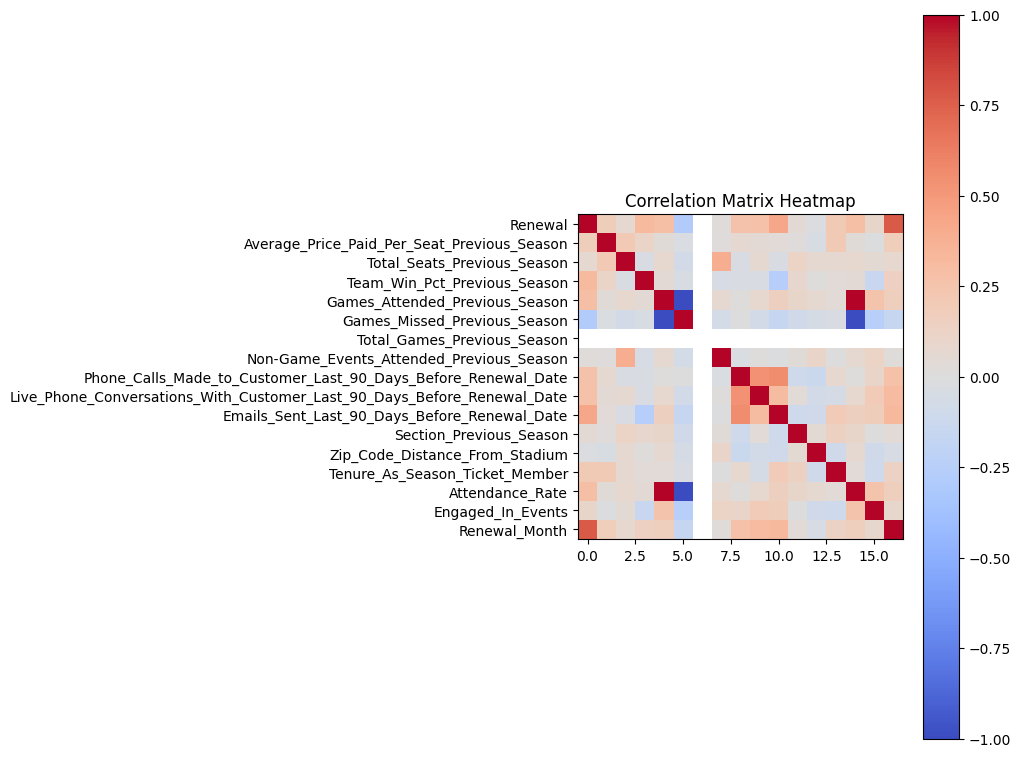

In [568]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()  # Adjust layout for better display
plt.show()

# 4. Model Building

In [569]:
# Feature Engineering
y = combined_data['Renewal']  # Target variable (1 for renewed, 0 for non-renewed)
X = combined_data.drop(columns=['Renewal'])  # Features

# Split the data and stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [570]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3024, 16), (3024,), (757, 16), (757,))

Let us fit 3 candidate models and perform hyperparameter tuning

### Logistic Regression

In [571]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}


# Random Search for Logistic Regression
log_reg_model = LogisticRegression()
log_reg_random = RandomizedSearchCV(estimator=log_reg_model, param_distributions=log_reg_param_grid,
                                     n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
log_reg_random.fit(X_train, y_train)

# Evaluate Logistic Regression
y_pred_log_reg = log_reg_random.predict(X_test)
print("Logistic Regression Best Parameters:", log_reg_random.best_params_)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_log_reg))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Logistic Regression Best Parameters: {'solver': 'liblinear', 'max_iter': 100, 'C': 1}
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        97
           1       1.00      0.99      0.99       660

    accuracy                           0.99       757
   macro avg       0.96      0.98      0.97       757
weighted avg       0.99      0.99      0.99       757

ROC-AUC Score: 0.9784754764136208


### XGBoost Classifier

In [572]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0]
}

# Random Search for XGBoost
xgb_model = XGBClassifier()
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid,
                                 n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_random.predict(X_test)
print("XGBoost Best Parameters:", xgb_random.best_params_)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_xgb))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
XGBoost Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        97
           1       1.00      1.00      1.00       660

    accuracy                           1.00       757
   macro avg       0.99      1.00      0.99       757
weighted avg       1.00      1.00      1.00       757

ROC-AUC Score: 0.9984848484848485


### Random Forest Classifier

In [573]:
# Define hyperparameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Random Search for Random Forest
rf_model = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid,
                               n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Evaluate Random Forest
y_pred_rf = rf_random.predict(X_test)
print("Random Forest Best Parameters:", rf_random.best_params_)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Random Forest Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 30, 'bootstrap': False}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        97
           1       1.00      1.00      1.00       660

    accuracy                           1.00       757
   macro avg       0.99      0.99      0.99       757
weighted avg       1.00      1.00      1.00       757

ROC-AUC Score: 0.9933302093095908


Since both XGBoost and Random Forest are giving us similar results, we can proceed with Random Forest as it is more explainable 

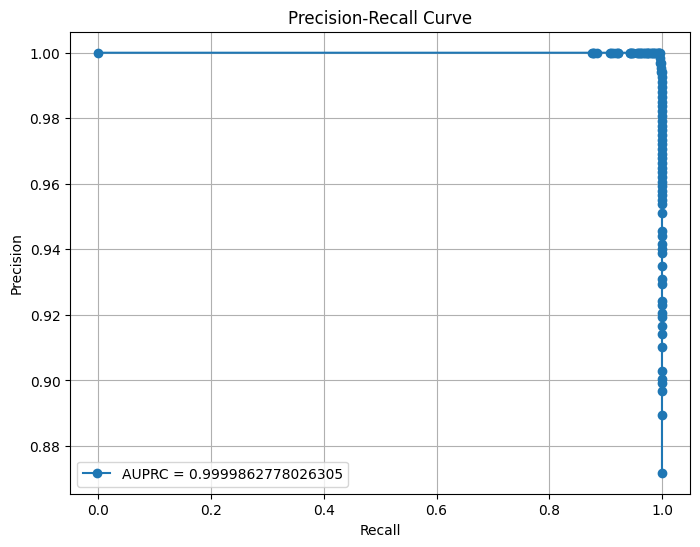

In [574]:
import matplotlib.pyplot as plt

# Assuming y_test contains true labels and y_scores contains predicted probabilities for the positive class
y_scores = rf_random.predict_proba(X_test)[:, 1]  

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auprc = auc(recall, precision)

# Plot AUPRC
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o', label=f'AUPRC = {auprc:.16f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.savefig("AUPRC.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

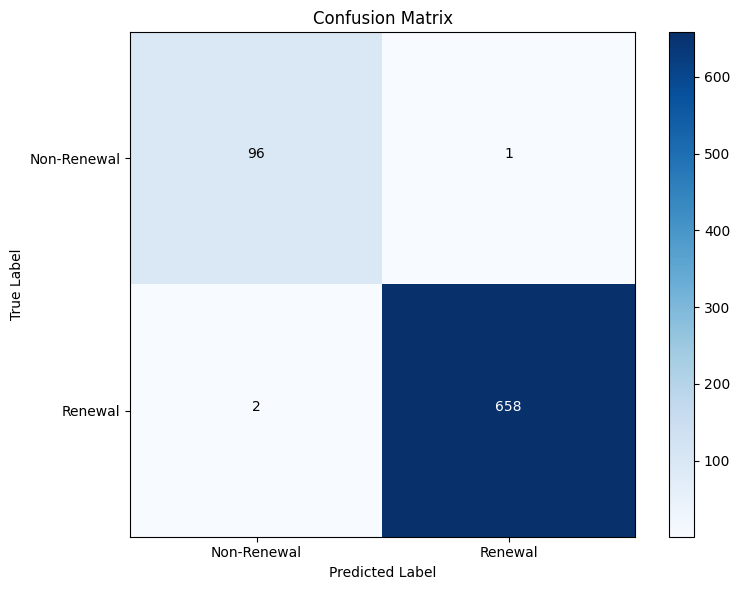

In [575]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Renewal', 'Renewal'])
plt.yticks(tick_marks, ['Non-Renewal', 'Renewal'])

# Loop over data dimensions and create text annotations
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("CM.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

<Figure size 1000x600 with 0 Axes>

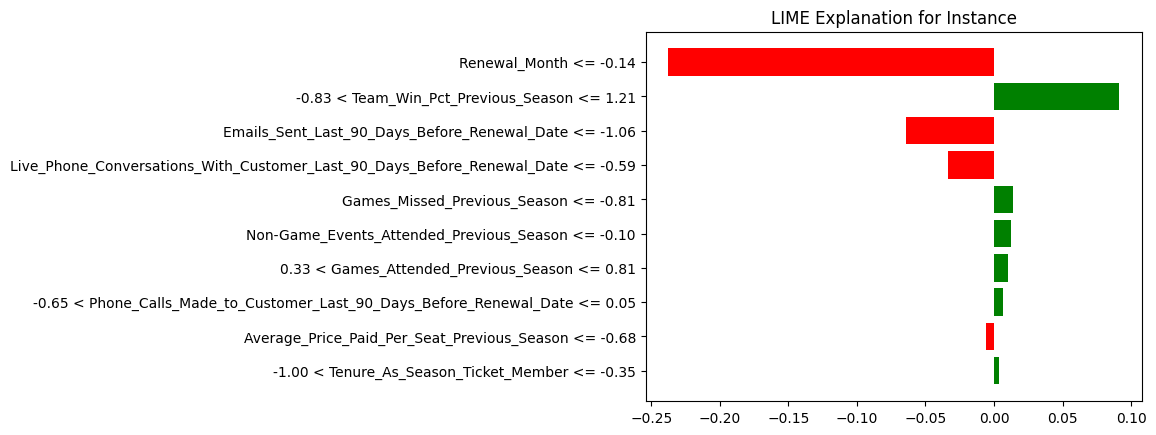

[CV] END .................C=0.01, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END .............C=0.01, max_iter=300, solver=liblinear; total time=   0.0s
[CV] END .................C=0.01, max_iter=300, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ..................C=0.1, max_iter=300, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ...............C=10, max_iter=200, solver=liblinear; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..................C=100, max_iter=100, solver=lbfgs; total time=   0.0s
[CV] END ..............C=100, max_iter=300, solver=liblinear; total time=   0.0s
[CV] END colsample_bytree=0.

In [576]:
# Create a LIME explainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['Not Renewed', 'Renewed'], mode='classification')

# Select an instance from the test set to explain
instance_to_explain = X_test_scaled[0]  # Change index to explain different instances

# Get LIME explanation
explanation = explainer.explain_instance(instance_to_explain, rf_random.best_estimator_.predict_proba)

# Plot the LIME explanation
plt.figure(figsize=(10, 6))
explanation.as_pyplot_figure()
plt.title("LIME Explanation for Instance")
plt.savefig("LIME.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# 5. Communicate Results

Prepared a powerpoint deck to explain results to stakeholders

# 6. Operationalize

## Operationalizing and Deploying the Retention Model

To run the retention model on a recurring basis, a production pipeline will automate data ingestion, inference, and monitoring. Below is a streamlined approach for deployment, monitoring, and maintenance.

### 1. Model Deployment and Automation
- **API Framework**: Use **FastAPI** or **Flask** to serve the model as a REST API.
- **Containerization**: Use **Docker** for a consistent deployment environment.
- **Orchestration**: Schedule with **cron jobs** or **Airflow** for automated workflows.
- **Cloud Platform**: Deploy to **AWS ECS**, **Google Cloud Run**, or **Azure App Service**.

### 2. Data Pipeline and Feature Engineering
- **ETL Tools**: Use **Airflow** for data ingestion and transformations.
- **Data Validation**: Ensure consistency to check data formats and prevent drift.

### 3. Monitoring and Logging
- **Performance Monitoring**: Track accuracy, precision, recall, and AUC-ROC and visualize with **Grafana**.
- **Alerting**: Set up alerts for performance drops or anomalies.

### 4. Model Retraining and Continuous Learning
- **Retraining Pipeline**: Use **Airflow** to schedule and execute retraining jobs.
- **Experiment Tracking**: Manage model versions and metrics with **MLflow**.
- **Deployment Strategy**: Implement **canary deployment** to gradually roll out model updates.

### 5. Maintenance and Best Practices
- **Model Versioning**: Use **MLflow** to track and manage model versions.
- **Documentation**: Maintain detailed documentation for collaboration and reference.
- **Security**: Implement secure data handling and compliance measures.

### Tools and Frameworks
- **Deployment**: FastAPI, Docker, AWS ECS
- **Scheduling**: Airflow, cron jobs
- **Monitoring**: Grafana
- **Logging**: Elasticsearch, MongoDB
- **Model Management**: MLflow

Disclaimer: Used ChatGPT to get context and to articulate my answers